In [183]:
# !pip install alive_progress
from scipy.io import savemat,loadmat
import scipy.io
import numpy as np
import os
from PIL import Image
import time
import sys
from alive_progress import alive_bar
import bar

resolusi=256

folder='E:\TA\dataset_sedikit'
files=os.listdir(folder)
kelas=-1*np.ones((len(files),1))

toolbar_width = len(files)
# toolbar_width = 5
img_rz=np.ones((toolbar_width,resolusi,resolusi,3))


for i in bar.progressbar(range(toolbar_width), "Proses Membaca File: ", 85):
    if files[i][0]=='a':
        kelas[i,0]=0
    elif files[i][0]=='b':
        kelas[i,0]=1
    elif files[i][0]=='e':
        kelas[i,0]=2
    elif files[i][0]=='p':
        kelas[i,0]=3
    image = Image.open(os.path.join(folder,files[i]))
    img_rz[i,:,:,:] = np.float64(np.array(image.resize((resolusi,resolusi))))

# print(kelas)
# print(img_rz.shape)
print("Jumlah File :"+str(len(files)))
print("Resolusi :"+str(img_rz.shape[1])+"x"+str(img_rz.shape[2])+"x"+str(img_rz.shape[3]))
print("Jumlah Kelas a :"+str(np.sum(kelas==0)))
print("Jumlah Kelas b :"+str(np.sum(kelas==1)))
print("Jumlah Kelas e :"+str(np.sum(kelas==2)))
print("Jumlah Kelas p :"+str(np.sum(kelas==3)))
var1={'Citra':img_rz,'Kelas':kelas,'Resolusi':resolusi}
savemat("datacitra.mat", var1)

Proses Membaca File: [#####################################################################################] 16/16

Jumlah File :16
Resolusi :256x256x3
Jumlah Kelas a :4
Jumlah Kelas b :4
Jumlah Kelas e :4
Jumlah Kelas p :4


Proses CS: [#####################################################################################] 16/16

Rasio Kompresi =12.5%


Text(0.5, 1.0, 'Citra Rek')

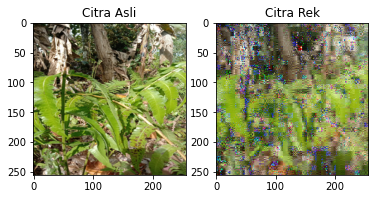

In [3]:
%reset -f
from PIL import Image
from numpy import asarray
import numpy as np
from matplotlib import pyplot
from scipy.fftpack import dct 
import math as mt
from scipy.fft import dctn, idctn
from scipy.io import savemat,loadmat
import recons
import bar

persen=0.125
windowsize_r = 8
windowsize_c = 8
thr=20

datacitra=loadmat("datacitra.mat")
img_rz=datacitra['Citra']
kelas=datacitra['Kelas']
resolusi=datacitra['Resolusi']
L=windowsize_r*windowsize_c
M=round(persen*windowsize_r*windowsize_c)
y=np.ones((M,round(img_rz.shape[1]*img_rz.shape[2]*img_rz.shape[3]/L),img_rz.shape[0]))
ysave=np.ones((img_rz.shape[0],M,round(img_rz.shape[1]*img_rz.shape[2]*img_rz.shape[3]/L)))

img_rr=np.ones((img_rz.shape[0],img_rz.shape[1],img_rz.shape[2],img_rz.shape[3]))
snr=np.ones((1,img_rz.shape[1]*img_rz.shape[2]*img_rz.shape[3]))
# print(str(img_rz.shape[3]))
# for j in range(0,img_rz.shape[3],1):
for j in bar.progressbar(range(img_rz.shape[0]), "Proses CS: ", 85):
#     print(str(j))
    ind=0
    sfile=False
    while sfile==False:
        single=False
        AA=np.random.normal(0,1,(M,L))
        # print("A1="+str(AA))
        md={'A':AA}
        savemat("dataA.mat", md)
        for i in range(0,img_rz.shape[3],1):
#             print(str(i))
            for r in range(0,img_rz.shape[1] , windowsize_r):
                for c in range(0,img_rz.shape[2] , windowsize_c):
                    w = img_rz[j,r:r+windowsize_r,c:c+windowsize_c,i]
                    wid1=w.reshape(windowsize_r*windowsize_c,1)
                    wd2=dctn(w[:,:])
                    wd=wd2.reshape(windowsize_r*windowsize_c,1)
                    data_dict=loadmat("dataA.mat")
                    AA=data_dict['A']
                    y[0:M,ind:ind+1,j]=np.dot(AA,wd)
                    Y=y[0:M,ind:ind+1,j]
                    ysave[j,0:M,ind:ind+1]=y[0:M,ind:ind+1,j]
                    try:
                        hat_x1=recons.omp(Y,AA)
                        
                    except:
#                         print('Singular')
                        single=True
                        break
                    snr[0,ind]=np.mean(np.mean(wd**2))/np.mean(np.mean((wd-hat_x1.T)**2))
                    hat_xt=hat_x1.reshape(windowsize_r*windowsize_c,1)

                    ind=ind+1
                    wdir=(hat_x1.T).reshape(windowsize_r,windowsize_c)
                    wid=idctn(wdir)
                    img_rr[j,r:r+windowsize_r,c:c+windowsize_c,i]=wid
                if single==True:
                    break
                if np.sum(snr>20)<thr:
                    break
            if single==True:
                break
            if np.sum(snr>20)<thr:
                break
            else:
                sfile=True
#                 print('True')
       
    I0 = img_rz[j,:,:,:].astype(np.uint8)
    I = img_rr[j,:,:,:].astype(np.uint8)
    mse=np.mean(np.mean((I-I0)**2))
    psnr=10*mt.log10(255**2/mse)
#     print("PSNR = "+str(psnr)+" dB")

print("Rasio Kompresi ="+str(persen*100)+"%")

fig, axs = pyplot.subplots(1,2)

axs[0].imshow(I0)
axs[0].set_title('Citra Asli')
axs[1].imshow(I)
axs[1].set_title('Citra Rek')

# axs[0].plot(wd)
# axs[0].set_title('Citra Asli')
# axs[1].plot(hat_xt)
# axs[1].set_title('Citra Rek')



In [97]:
print(img_rr.shape)
print(kelas.shape)

(80, 256, 256, 3)
(80, 1)


(12, 256, 256, 3)
(4, 256, 256, 3)
(12, 256, 256, 3)
(4, 4)
(12, 4)


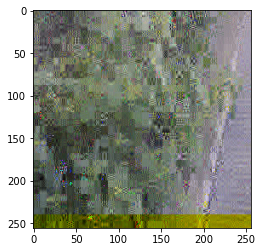

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
from sklearn.model_selection import train_test_split


indices = np.arange(img_rr.shape[0])
# (
#     data_train,
#     data_test,
#     labels_train,
#     labels_test,
#     indices_train,
#     indices_test,
# ) = train_test_split(data, labels, indices, test_size=0.2)


kelas=kelas[0:img_rr.shape[0]]
# x_train, x_test, y_train, y_test,ind_train,ind_test = train_test_split(img_rz, kelas, indices, test_size=.25) #asli
x_train, x_test, y_train, y_test,ind_train,ind_test = train_test_split(img_rr, kelas, indices, test_size=.25) #rekonstruksi
# x_train, x_test, y_train, y_test,ind_train,ind_test = train_test_split(ysave, kelas, indices, test_size=.25) #hasil cs

# (X_train, y_train), (X_test, y_test) = mnist.load_data()

# x_train = x_train.reshape(1, resolusi[0,0],resolusi[0,0],3)
# x_test = x_test.reshape(1, resolusi[0,0],resolusi[0,0],3)

# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# x_train /= 255
# x_test /= 255
# norm = np. linalg. norm(x_train)
# x_train = x_train/norm
# norm = np. linalg. norm(x_test)
# x_test = x_test/norm

y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)
# X_test[1,:]
# print(y_train)
print(x_train.shape)
I0 = x_train.astype(np.uint8)
#     I = img_rr[j,:,:,:].astype(np.uint8)
plt.imshow(I0[1])

print(x_test.shape)
print(x_train.shape)
print(y_test.shape)
print(y_train.shape)


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# print(x_train.shape)
#Convolutional Neural Network
# print(resolusi[0])
model2 = Sequential()
# model2.add(Conv2D(16,(3,3),activation='relu',input_shape=(resolusi[0,0],resolusi[0,0],3),padding='same'))
# model2.add(Conv2D(16,(3,3),activation='relu',input_shape=(8,3072,1),padding='same'))
if x_train.ndim==3:
    model2.add(Conv2D(16,(3,3),activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],1),padding='same'))
else:
    model2.add(Conv2D(16,(3,3),activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]),padding='same'))

model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model2.add(MaxPooling2D(2,2))

model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(Dense(4,activation='softmax'))
# model2.summary()

model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

history2 = model2.fit(x_train,y_train,epochs=30,batch_size=150,validation_data=(x_test,y_test))#batch size def : 100
model2.save('my_model2.h5')



Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 47.3134 - acc: 0.4167 - val_loss: 6379.8892 - val_acc: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 1s 1s/step - loss: 4356.6602 - acc: 0.3333 - val_loss: 2835.0986 - val_acc: 0.5000
Epoch 3/30
1/1 [==============================] - 1s 1s/step - loss: 5475.3477 - acc: 0.1667 - val_loss: 3977.2966 - val_acc: 0.2500
Epoch 4/30
1/1 [==============================] - 1s 1s/step - loss: 4233.7080 - acc: 0.2500 - val_loss: 3824.6431 - val_acc: 0.2500
Epoch 5/30
1/1 [==============================] - 1s 1s/step - loss: 2484.7722 - acc: 0.2500 - val_loss: 2614.1514 - val_acc: 0.0000e+00
Epoch 6/30
1/1 [==============================] - 1s 1s/step - loss: 971.9672 - acc: 0.5833 - val_loss: 2066.5090 - val_acc: 0.0000e+00
Epoch 7/30
1/1 [==============================] - 1s 1s/step - loss: 606.1135 - acc: 0.4167 - val_loss: 924.7509 - val_acc: 0.0000e+00
Epoch 8/30
1/1 [==============================] - 2s 2s/st

(4, 256, 256, 3)
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
[[1.1742482e-04 9.9988258e-01 4.7339666e-10 3.0101153e-09]
 [1.0000000e+00 3.8084073e-16 3.4631360e-33 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.1938248e-01 8.8061756e-01 0.0000000e+00 0.0000000e+00]]
0


ValueError: Classification metrics can't handle a mix of binary and continuous targets

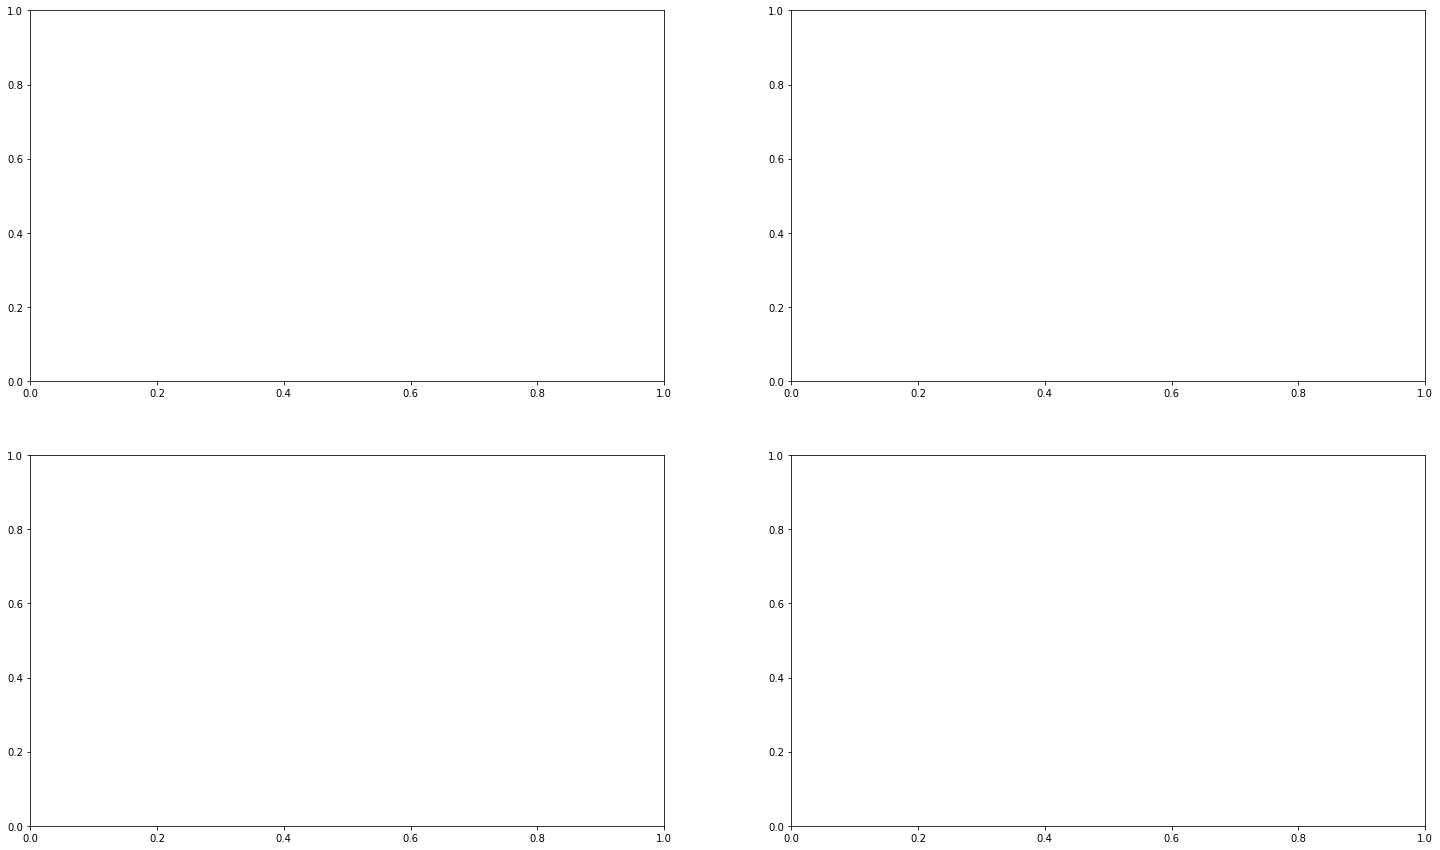

In [8]:
from keras.models import load_model

print(x_test.shape)
# print(x_train.shape)
# print(y_test.shape)
# print(y_train.shape)

model2save = load_model('my_model2.h5')

y_pred = model2save.predict(x_test)
# print(y_pred.shape)
# print(y_test.shape)
# print(x_test)

# accuracy = accuracy_score(y_test, y_pred)
# print('Akurasi Testing CNN:', accuracy)
# plot_confusion_matrix(model2, x_test, y_test)

print(y_test)
print(y_pred)


# y_testb = [np.argmax(y, axis=None, out=None) for y in y_test]
# y_predb = [np.argmax(y, axis=None, out=None) for y in y_pred]



# print(y_testb)
# print(y_predb)

f, axes = plt.subplots(2, 2, figsize=(25, 15))
axes = axes.ravel()
for i in range(4):
    print(i)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:,i],
                                                   y_pred[:,i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [9]:
model2.evaluate(x_test,y_test)

pred = model2.predict(x_test)
print('label actual:',np.argmax(y_test[3]))
print('label prediction:',np.argmax(pred[3]))
print(y_test)
print(pred)

1/1 [==============================] - 0s 152ms/step - loss: 359.0823 - acc: 0.0000e+00
label actual: 3
label prediction: 1
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
[[1.1742482e-04 9.9988258e-01 4.7339666e-10 3.0101153e-09]
 [1.0000000e+00 3.8084073e-16 3.4631360e-33 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.1938248e-01 8.8061756e-01 0.0000000e+00 0.0000000e+00]]


In [94]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

#model 1 menggunakan Multilayer Neural Network

model1 = Sequential()
model1.add(Flatten())
model1.add(Dense(64,activation='relu'))
model1.add(Dense(4,activation='softmax'))


model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
history1 = model1.fit(x_train,y_train,epochs=100,batch_size=100,validation_data=(x_test,y_test))
model1.save('my_model.h5')

model1.evaluate(x_test,y_test)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 136.2284 - acc: 0.2500 - val_loss: 28111.3711 - val_acc: 0.2500
Epoch 2/100
1/1 [==============================] - 0s 177ms/step - loss: 27575.5215 - acc: 0.2500 - val_loss: 26523.1016 - val_acc: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 181ms/step - loss: 27910.1328 - acc: 0.5000 - val_loss: 29339.5410 - val_acc: 0.2500
Epoch 4/100
1/1 [==============================] - 0s 174ms/step - loss: 29988.5625 - acc: 0.2500 - val_loss: 23719.1152 - val_acc: 0.2500
Epoch 5/100
1/1 [==============================] - 0s 193ms/step - loss: 23114.7559 - acc: 0.2500 - val_loss: 13314.8135 - val_acc: 0.2500
Epoch 6/100
1/1 [==============================] - 0s 191ms/step - loss: 11606.1719 - acc: 0.3333 - val_loss: 3124.5405 - val_acc: 0.2500
Epoch 7/100
1/1 [==============================] - 0s 174ms/step - loss: 1613.1671 - acc: 0.4167 - val_loss: 9024.4014 - val_acc: 0.2500
Epoch 8/100
1/1 [==================

[8533.28515625, 0.5]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(250, 15)


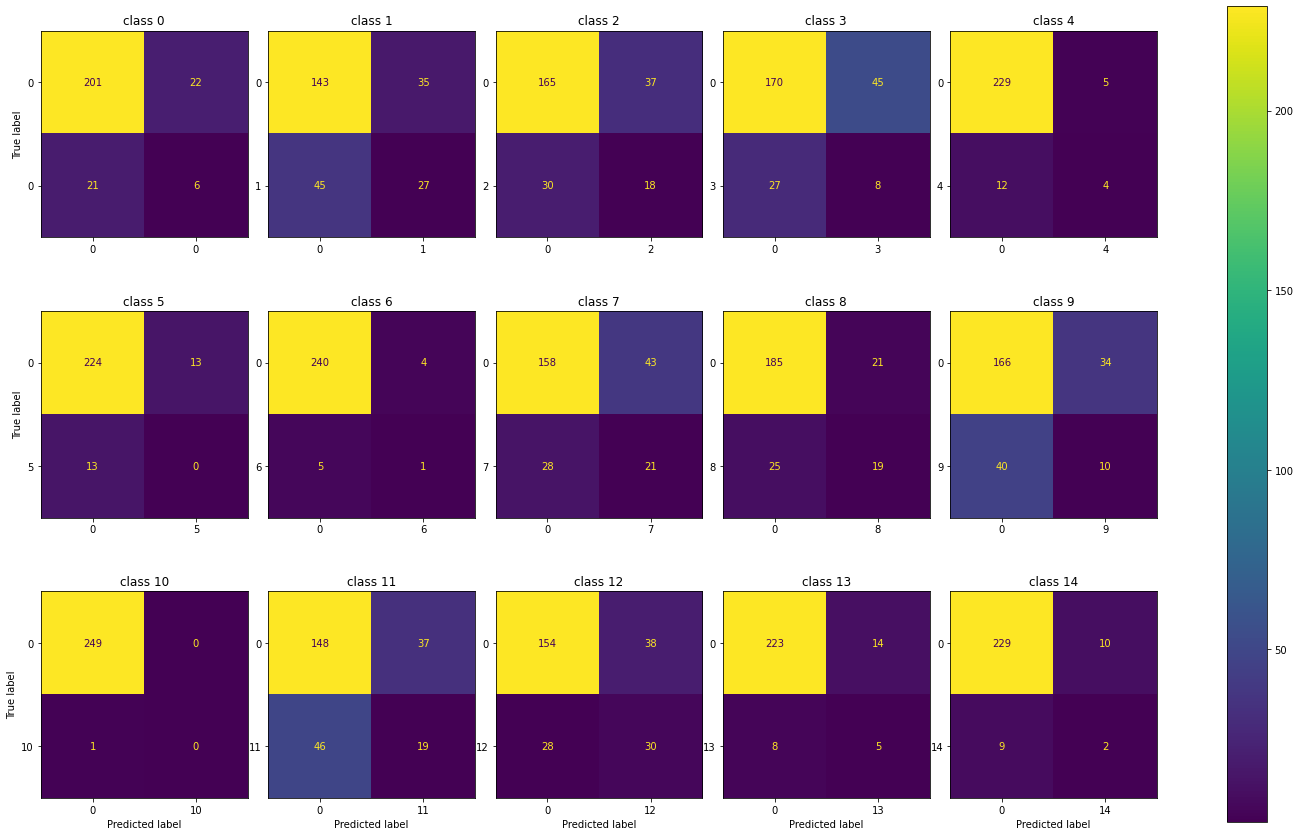

In [133]:
# !pip install mat73
# !pip install ipynb
# pip install opencv-python

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier

X, y = make_multilabel_classification(n_samples=1000,
                                      n_classes=15, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

y_pred = tree.predict(X_test)
print(y_test)
print(y_test.shape)
f, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.ravel()
for i in range(15):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                   y_pred[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()


In [ ]:
import cv2
import numpy as np
from PIL import Image

# img_file = "sample.jpg"
image = cv2.imread(x)

# USING NUMPY SLICE
red = image[:,:,2]
green = image[:,:,1]
blue = image[:,:,0]

pyplot.imshow(blue)

from numpy import linalg as LA



def omp(y0,A0):
    s=mt.ceil(len(y0))
    # print(s)
    a=np.zeros((A0.shape[0],0))
    pos=np.zeros((1,s))
    r_n=y0
#     print(np.sum(r_n))
    if np.sum(r_n)==0:
        hat_x=np.zeros((1,A0.shape[1]))
        return hat_x
    # s=2
    for k in range(0,s,1):
        pr=abs(np.dot(A0.T,r_n))
    #     print(pr)
        posx=np.argmax(pr)
#         A.shape
#         y.shape
        a=np.column_stack((a,A0[:,posx]))
        A0[:,posx]=np.zeros((1,y0.shape[0]))
        aa=np.dot(a.T,a)
    #     print(aa)
#         print(y)
#         y.shape
        pangkat=LA.matrix_power(aa,-1)
        aug_x=np.dot(np.dot(pangkat,a.T),y0)    
        r_n=y0-np.dot(a,aug_x)
    #     print(k)
        pos[0,k]=posx

    hat_x=np.zeros((1,A0.shape[1]))
    for k in range(0,len(aug_x),1):
    #     print(pos[0,k])
        hat_x[0,round(pos[0,k])]=aug_x[k]
#     print(A)
#     print("Ukuran A ="+str(A.shape))
    return hat_x




# def omp(y,A):
#     s=mt.ceil(len(y))
#     # print(s)
#     a=np.zeros((A.shape[0],0))
#     pos=np.zeros((1,s))
#     r_n=y
# #     print(np.sum(r_n))
#     if np.sum(r_n)==0:
#         hat_x=np.zeros((1,A.shape[1]))
#         return hat_x
#     # s=2
#     for k in range(0,s,1):
#         pr=abs(np.dot(A.T,r_n))
#     #     print(pr)
#         posx=np.argmax(pr)
# #         A.shape
# #         y.shape
#         a=np.column_stack((a,A[:,posx]))
#         A[:,posx]=np.zeros((1,y.shape[0]))
#         aa=np.dot(a.T,a)
#     #     print(aa)
# #         print(y)
# #         y.shape
#         pangkat=LA.matrix_power(aa,-1)
#         aug_x=np.dot(np.dot(pangkat,a.T),y)    
#         r_n=y-np.dot(a,aug_x)
#     #     print(k)
#         pos[0,k]=posx

#     hat_x=np.zeros((1,A.shape[1]))
#     for k in range(0,len(aug_x),1):
#     #     print(pos[0,k])
#         hat_x[0,round(pos[0,k])]=aug_x[k]
# #     print(A)
# #     print("Ukuran A ="+str(A.shape))
#     return hat_x



In [ ]:
y=np.array([[1,2,3,4],[1,1,0,0]])
A=np.array([[1,2,3,4],[1,1,0,0]])
wdc=np.array([[1],[-2],[0],[-1]])

y[0:2,0:1]=np.dot(A,wdc)
# y[0:2,0]=100
print(y.shape)
# import numpy as numpy

# grey_levels = 256
# # Generate a test image
# test_image = numpy.random.randint(0,grey_levels, size=(11,11))

# # Define the window size
# windowsize_r = 5
# windowsize_c = 5

# # Crop out the window and calculate the histogram
# for r in range(0,test_image.shape[0] - windowsize_r, windowsize_r):
#     for c in range(0,test_image.shape[1] - windowsize_c, windowsize_c):
#         window = test_image[r:r+windowsize_r,c:c+windowsize_c]
#         hist = numpy.histogram(window,bins=grey_levels)



# def name():
#     return "John","Armin"

# # print the tuple with the returned values
# print(name())

# # get the individual items
# name_1, name_2 = name()
# print(name_1, name_2)

In [ ]:
pr=np.array([1,2,3,4,5,3,2,1])
x=np.argmax(pr)
print(max(pr))
print(x)

In [ ]:
a = np.array((0, 1))
b = np.array((2, 1))
c = np.array((-1, -1))
x=np.column_stack((a,b,c))
x.shape
print(a)
print(x)


In [ ]:
from numpy import linalg as LA
persen=0.125/2
windowsize_r = 2
windowsize_c = 2
L=windowsize_r*windowsize_c
# wid=img
M=round(persen*windowsize_r*windowsize_c)
M=2
# A=np.random.normal(0,1,(M,L))
A=np.array([[-0.5377,  -1.2588,   3.188,   -0.4336],
    [0.8339,    0.8622,   -1.3077,    -0.3426]])

# print(A.shape)


x=np.array([1,0.5,0.1,0]).T[:, np.newaxis]
# x1=np.transpose(x)
# print(x)
# print(np.shape(x))
y=np.dot(A,x)

s=mt.ceil(len(y))
# print(s)
a=np.zeros((A.shape[0],0))
pos=np.zeros((1,s))
r_n=y
# s=2
for k in range(0,s,1):
    pr=abs(np.dot(A.T,r_n))
#     print(pr)
    posx=np.argmax(pr)
    a=np.column_stack((a,A[:,posx]))
    A[:,posx]=np.zeros((1,y.shape[0]))
    aa=np.dot(a.T,a)
#     print(aa)
    pangkat=LA.matrix_power(aa,-1)
    aug_x=np.dot(np.dot(pangkat,a.T),y)    
    r_n=y-np.dot(a,aug_x)
#     print(k)
    pos[0,k]=posx
    
hat_x=np.zeros((1,A.shape[1]))
for k in range(0,len(aug_x),1):
#     print(pos[0,k])
    hat_x[0,round(pos[0,k])]=aug_x[k]

# pos[0,0]=posx  
print(pr)
print(aa)
print(a)
print(k)
print(posx)
print(aug_x)
print(r_n)
print(A)
print(pos)
print(hat_x)
print(s)
# y.shape[0]

In [ ]:
a=np.zeros((3,0))
b=np.array([1,2,3]).T
a=np.column_stack((a,b))
print(a)
a=np.column_stack((a,b))
print(a)


In [ ]:
print(A.shape[1])